In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    #google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"    
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

2023-04-14 08:22:18.570253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running locally on beta.


In [2]:
from data_gen.synth_sequences import SynthNNumbers
import models
import utils

In [3]:
P = {}

P["SynthNNumbers"] = {
    "batch_size" : 32,
    "n" : 2,
    "operation" : "multiply",
    "limit" : 2,
    "distribution" : "uniform",
    "seed" : 42,
}

data_gen = SynthNNumbers(**P["SynthNNumbers"])
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)
print(x[0], y[0])

(32, 2) float32 (32,) float32
[ 1.0958242  -0.24448624] -0.26791394


In [19]:
class LogWeightNorms(tf.keras.callbacks.Callback):

    def __init__(self):
        super().__init__()
        self.reset_norms()

    def on_epoch_end(self, epoch, logs=None):
        self.weight_norms.append(self.calc_norms())

    def calc_norms(self):
        return [ np.linalg.norm(w.reshape(-1)) for w in self.model.get_weights() ]

    def reset_norms(self):
        self.weight_norms = []

    def norms_dataframe(self):
        num_cols = len(self.weight_norms[0])
        num_rows = len(self.weight_norms)
        col_names = [ f"w_norm_{c:02d}" for c in range(num_cols) ]
        df = pd.DataFrame(self.weight_norms, columns=col_names, index=range(1, num_rows+1))
        df.index.name = "epoch"
        return df
    
    def norms_to_csv(self, directory):
        self.norms_dataframe().to_csv(os.path.join(directory, "weight_norms.csv"), index=True)
        

weight_norm_logger = LogWeightNorms()


In [20]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 32,
    "num_outputs" : 1,
    "input_shape" : (P["SynthMathData"]["seq_len"], 2),
    "num_hidden_gru" : 3,
    "use_embedding" : False,
    "return_final_hidden" : True,
}

model = tf.keras.Sequential([
    tf.keras.Input(shape=(P["SynthNNumbers"]["n"],)),
    utils.Quadratic(1)
])

'''

P["model_name"] = "mlp_01"
P["model_build_params"] = {
    "input_shape" : (P["SynthNNumbers"]["n"],),
    "layer_units" : [ 128, 1 ],
    "activations" : [ "relu", "linear" ],
    "use_bias" : True,
}

model = eval("models." + P["model_name"])(**P["model_build_params"])

model.compile(
    loss = "mse",
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2, weight_decay=1),
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-3, weight_decay=1),
    metrics = [ "mae" ]
)

model.summary()

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
print("Run dir :", P["run_dir"])

run = utils.TrainingRun()

Model: "mlp_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 128)               384       
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Run dir : mlp_01-230414-084104


In [21]:
NUM_EPOCHS = 1024 // 16
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    data_gen,
    epochs = NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
        weight_norm_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

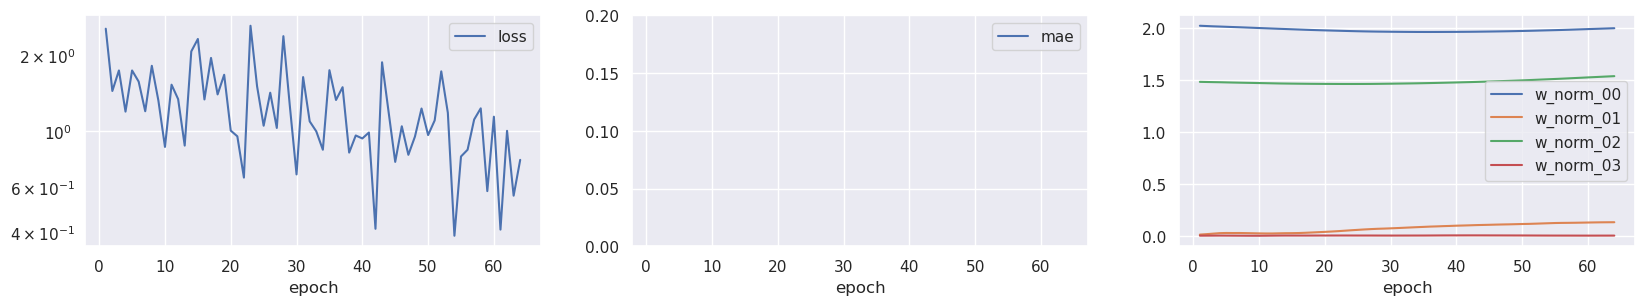

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,3))

sns.lineplot(data=run.history[["loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["mae"]], ax=axs[1], dashes=False);
axs[1].set_ylim(0,0.2);

sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [115]:
model.compile(
    loss = "mse",
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2, weight_decay=1),
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=1e-4, weight_decay=1),
    metrics = [ "mae" ]
)

In [25]:
log_dir = os.path.join(OUTPUT_DIR, P["run_dir"])
run.save_state(log_dir, P, model)
weight_norm_logger.norms_to_csv(log_dir)

1/1 [==============================] - 0s 41ms/step


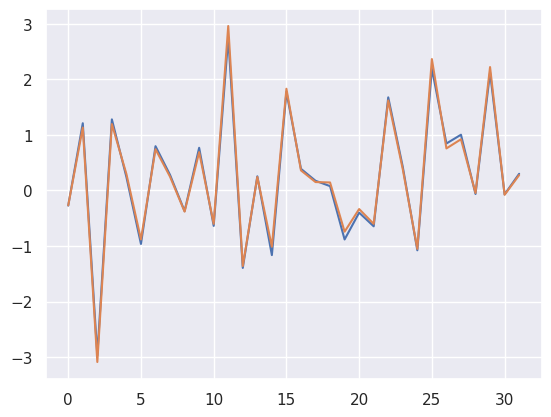

In [20]:
y_pred = model.predict(x)
plt.plot(y_pred)
plt.plot(y)

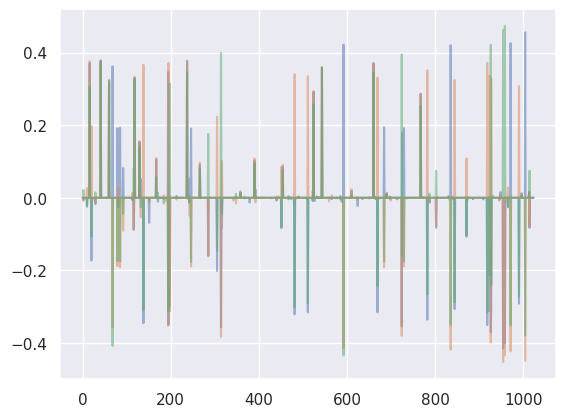

In [22]:
plt.plot(model.get_weights()[0].T, alpha=0.5);
plt.plot(model.get_weights()[1], alpha=0.5);

313/313 [==============================] - 0s 1ms/step


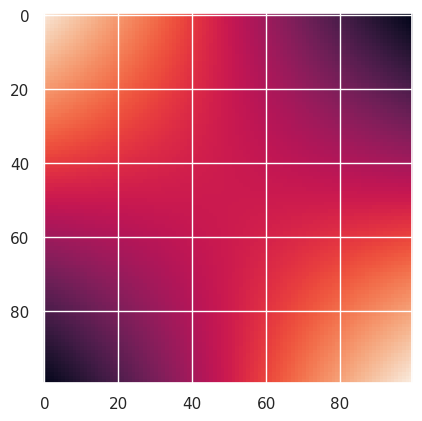

In [36]:
x_test = np.array([ [x1, x2] for x2 in np.linspace(-1,1,100) for x1 in np.linspace(-1,1,100) ])
y_test = np.prod(x_test, axis=-1)

y_pred = model.predict(x_test)

plt.imshow(y_pred.reshape(100,100));

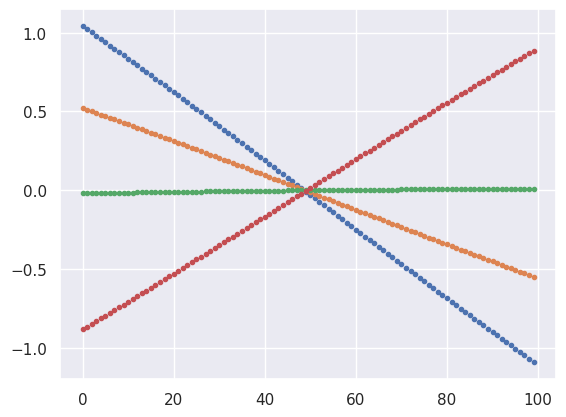

In [37]:
plt.plot(y_pred.reshape(100,100)[0], ".");
plt.plot(y_pred.reshape(100,100)[25], ".");
plt.plot(y_pred.reshape(100,100)[50], ".");
plt.plot(y_pred.reshape(100,100)[90], ".");